# Action Detection (Final)
- only using RH and LH keypoints
- implement checkpoints to save best model

Notes for future improvements:
1. FACEMESH can map slightly over 1k keypoints on the face, and pose can map 132. 
    - FACEMESH can introduce possibility to include facial expressions that can pair with handsigns to help better translate the word, as there are some handsigns that can have another meaning based on context/ emotions
    - POSE can help in terms of real life scenario and filming the whole body with the phone or more of the upper body, and it can be taken into account to improve accuracy
    * However, as our dataset is very small, we will not be using these points as they negatively influence the prediction. Implementation will need more work in this area
2. Can include a demo for mediapipe in terms of full capabilities (or just take from their website)

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import pyttsx3
# !pip3 freeze

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [59]:
# Check camera set up
cap = cv2.VideoCapture(0)
# Set mediapipe model: instantiate the model to fit into detection function
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read frame from webcam, return value, frame: image from webcam
        ret, frame = cap.read()

        # Feed webcam image to mediapipe to Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [30]:
cap.release()
cv2.destroyAllWindows()

## Setup Folder Collection

In [131]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('hire') 

# Actions that we try to detect
actions = np.array(['please', 'hire', 'me', 'google'])
# actions = np.array(['please', 'hire'])

# Thirty videos worth of data
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 30

In [114]:
actions.shape[0]

2

In [116]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Collect keypoints for training

In [120]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length, each frame, 30 frames of keypoints for each video
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence+50), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

FileNotFoundError: [Errno 2] No such file or directory: 'hire2\\please\\50\\0.npy'

In [121]:
cap.release()
cv2.destroyAllWindows()

## Training Model

### Preprocess Data

In [97]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [132]:
label_map = {label:num for num, label in enumerate(actions)}

In [133]:
label_map

{'please': 0, 'hire': 1, 'me': 2, 'google': 3}

In [134]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [135]:
# Check shape: (videos, frames, keypoints), adjust LSTM input accordingly
np.array(sequences).shape

(192, 30, 126)

In [136]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [137]:
X_train=X
y_train=y

In [ ]:
# Train test split (skip for more train data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_seed=0)

### Model Training

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model, callbacks
# from tensorflow.keras.callbacks import TensorBoard

In [16]:
# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)

In [138]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [139]:
early_stopping = EarlyStopping(monitor='categorical_accuracy', min_delta=0.001, patience=100, verbose=1, mode='auto', restore_best_weights=True)

In [140]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [141]:
model.fit(X_train, y_train, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
6/6 [==============================] - 0s 62ms/step - loss: 1.3159 - categorical_accuracy: 0.3333
Epoch 2/1000
6/6 [==============================] - 0s 58ms/step - loss: 1.3038 - categorical_accuracy: 0.3021 0s - loss: 1.3682 - categorical_accuracy: 
Epoch 3/1000
6/6 [==============================] - 0s 66ms/step - loss: 1.2561 - categorical_accuracy: 0.3490
Epoch 4/1000
6/6 [==============================] - 0s 61ms/step - loss: 1.2633 - categorical_accuracy: 0.4948
Epoch 5/1000
6/6 [==============================] - 0s 60ms/step - loss: 1.1798 - categorical_accuracy: 0.3490
Epoch 6/1000
6/6 [==============================] - 0s 63ms/step - loss: 1.0378 - categorical_accuracy: 0.5052
Epoch 7/1000
6/6 [==============================] - 0s 55ms/step - loss: 0.9170 - categorical_accuracy: 0.5729
Epoch 8/1000
6/6 [==============================] - 0s 60ms/step - loss: 0.8577 - categorical_accuracy: 0.5052
Epoch 9/1000
6/6 [==============================] - 0s 65ms/step - lo

6/6 [==============================] - 0s 64ms/step - loss: 0.1932 - categorical_accuracy: 0.9062
Epoch 74/1000
6/6 [==============================] - 0s 66ms/step - loss: 0.1934 - categorical_accuracy: 0.9115
Epoch 75/1000
6/6 [==============================] - 0s 63ms/step - loss: 0.2251 - categorical_accuracy: 0.8750
Epoch 76/1000
6/6 [==============================] - 0s 60ms/step - loss: 0.2012 - categorical_accuracy: 0.9062
Epoch 77/1000
6/6 [==============================] - 0s 62ms/step - loss: 0.2030 - categorical_accuracy: 0.8854
Epoch 78/1000
6/6 [==============================] - 0s 67ms/step - loss: 0.2044 - categorical_accuracy: 0.8854
Epoch 79/1000
6/6 [==============================] - 0s 67ms/step - loss: 0.2024 - categorical_accuracy: 0.8802
Epoch 80/1000
6/6 [==============================] - 0s 67ms/step - loss: 0.1857 - categorical_accuracy: 0.9115
Epoch 81/1000
6/6 [==============================] - 0s 68ms/step - loss: 0.1798 - categorical_accuracy: 0.9167
Epoch 

6/6 [==============================] - 0s 65ms/step - loss: 0.8669 - categorical_accuracy: 0.7812
Epoch 146/1000
6/6 [==============================] - 0s 66ms/step - loss: 1.0929 - categorical_accuracy: 0.7396
Epoch 147/1000
6/6 [==============================] - 0s 65ms/step - loss: 1.2133 - categorical_accuracy: 0.4167
Epoch 148/1000
6/6 [==============================] - 0s 67ms/step - loss: 0.9281 - categorical_accuracy: 0.6094
Epoch 149/1000
6/6 [==============================] - 0s 67ms/step - loss: 0.8871 - categorical_accuracy: 0.6562
Epoch 150/1000
6/6 [==============================] - 0s 67ms/step - loss: 0.8306 - categorical_accuracy: 0.7448
Epoch 151/1000
6/6 [==============================] - 0s 56ms/step - loss: 0.7565 - categorical_accuracy: 0.7812
Epoch 152/1000
6/6 [==============================] - 0s 68ms/step - loss: 0.6768 - categorical_accuracy: 0.8281
Epoch 153/1000
6/6 [==============================] - 0s 64ms/step - loss: 0.6115 - categorical_accuracy: 0.828

In [142]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 30, 64)            48896     
_________________________________________________________________
lstm_37 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
lstm_38 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 132       
Total params: 203,492
Trainable params: 203,492
Non-trainable params: 0
_______________________________________________

In [143]:
model.save('hire_v2.h5')

In [65]:
# model.load_weights('sentence1.h5')

## Test Detection

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define actions
actions = np.array(['hire', 'me', 'please', 'Google'])
# actions = np.array(["i'm", 'doing', 'well', 'thanks'])
# actions = np.array(['let', 'us', 'discuss', 'our', 'plan'])

# Model import
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# model.load_weights('sentence1_v2.h5')
# model.load_weights('sentence3_v2.h5')
model.load_weights('action_hireme_rhlh.h5')


In [112]:
# 1. New detection variables
sequence = []        #collect the 30 frames to generate a prediction
sentence = []        #concat history of detections
predictions = []
max_words = 8
threshold = 0.9

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# tts = pyttsx3.init()           #for tts
# tts.setProperty('rate', 85)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]   
        
#         once sequence has 30 frames
        if len(sequence) == 30: 
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0:                         
                        if actions[np.argmax(res)] != sentence[-1]:    #append only if next action is different
                            sentence.append(actions[np.argmax(res)])
                            
#                             tts.say(actions[np.argmax(res)])
#                             tts.runAndWait()
                    else:
                        sentence.append(actions[np.argmax(res)])
#                         tts.say(actions[np.argmax(res)])
#                         tts.runAndWait()

            if len(sentence) > max_words:          #just grab the last 5 values when sentence has more than 6 words
                sentence = sentence[-max_words:]
            
        cv2.rectangle(image, (0,0), (1280, 40), (245, 139, 76), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),                                 # (left-right, up-down)
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
      
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [18]:
# Testing text to speech
s = pyttsx3.init()           #for tts
s.setProperty('rate', 100)     # setting up new voice rate
voices = s.getProperty('voices') 
s.setProperty('voice', voices[0].id)  #change voice
data = "giddy"  
s.say(data)  
s.runAndWait()  

### Testing improved logic

In [148]:
# 1. New detection variables
sequence = []        #collect the 30 frames to generate a prediction
sentence = []        #concat history of detections
predictions = []
max_words = 8
threshold = 0.7

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# tts = pyttsx3.init()           #for tts
# tts.setProperty('rate', 85)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        
        if results.right_hand_landmarks or results.left_hand_landmarks:
            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
        
            # Make prediction once there is 30 frames in the sequence
            if len(sequence) == 30: 
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                
                # Vizualisation logic
                if np.unique(predictions[-10:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 

                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1] and actions[np.argmax(res)] not in sentence:   #DAMN HACK HERE #append only if next action is different
                                sentence.append(actions[np.argmax(res)])
    #                             tts.say(actions[np.argmax(res)])
    #                             tts.runAndWait()
                        else:
                            sentence.append(actions[np.argmax(res)])
    #                         tts.say(actions[np.argmax(res)])
    #                         tts.runAndWait()
        
        else:
            pass
            
            if len(sentence) > max_words:          #just grab the last 5 values when sentence has more than 6 words
                sentence = sentence[-max_words:]
            
        cv2.rectangle(image, (0,0), (1280, 40), (245, 139, 76), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),                                 # (left-right, up-down)
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
      
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [78]:
cap.release()
cv2.destroyAllWindows()

### GIF Demo

In [170]:
# With hire_v2
# 1. New detection variables
sequence = []        #collect the 30 frames to generate a prediction
sentence = []        #concat history of detections
predictions = []
max_words = 8
threshold = 0.6

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# tts = pyttsx3.init()           #for tts
# tts.setProperty('rate', 85)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        
        if results.right_hand_landmarks or results.left_hand_landmarks:
            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
        
            # Make prediction once there is 30 frames in the sequence
            if len(sequence) == 30: 
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                
                # Vizualisation logic
                if np.unique(predictions[-10:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 

                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1] and actions[np.argmax(res)] not in sentence:   #DAMN HACK HERE #append only if next action is different
                                sentence.append(actions[np.argmax(res)])
    #                             tts.say(actions[np.argmax(res)])
    #                             tts.runAndWait()
                        else:
                            sentence.append(actions[np.argmax(res)])
    #                         tts.say(actions[np.argmax(res)])
    #                         tts.runAndWait()
        
        else:
            pass
            
            if len(sentence) > max_words:          #just grab the last 5 values when sentence has more than 6 words
                sentence = sentence[-max_words:]
            
        cv2.rectangle(image, (0,0), (1280, 70), (245, 139, 76), -1)
        cv2.putText(image, ' '.join(sentence), (15, 50),                                 # (left-right, up-down)
                       cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
      
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define actions
actions = np.array(['hire', 'me', 'please', 'Google'])
# actions = np.array(["i'm", 'doing', 'well', 'thanks'])
# actions = np.array(['let', 'us', 'discuss', 'our', 'plan'])

# Model import
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# model.load_weights('sentence1_v2.h5')
# model.load_weights('sentence3_v2.h5')
model.load_weights('action_hireme_rhlh.h5')


In [179]:
# 1. New detection variables
sequence = []        #collect the 30 frames to generate a prediction
sentence = []        #concat history of detections
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]   
        
#         once sequence has 30 frames
        if len(sequence) == 30: 
            # model expects (1, 30, 258), current sequence (30, 258)
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1] and actions[np.argmax(res)] not in sentence:    #append only if next action is different
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:          #just grab the last 5 values when sentence has more than 5 words
                sentence = sentence[-5:]

#             # Viz probabilities
#             image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

### Mediapipe Holistic Demo

In [ ]:
# Video demo for Mediapipe Holistic
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Check camera set up
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Set mediapipe model: instantiate the model to fit into detection function
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read frame from webcam, return value, frame: image from webcam
        ret, frame = cap.read()

        # Feed webcam image to mediapipe to Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

## Convert to tflite

In [80]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('sentence1.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: C:\Users\wushen\AppData\Local\Temp\tmp_mad_k0k\assets


INFO:tensorflow:Assets written to: C:\Users\wushen\AppData\Local\Temp\tmp_mad_k0k\assets


In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

# Action Detection Refined
- edited section to exclude FACEMESH_TESSELATION 

## 1. Import and Install Dependencies

In [3]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 mediapipe sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1320 sha256=aa69acdab25590a0f1ccb34f5b896debbd33315941c68d98d20b53939f9acd41
  Stored in directory: c:\users\wushen\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=38ad63ea8eaa28d8cdea9b53016d60f095bb63e2d098d38f0b46b876074bdc1a
  Stored in directory: c:\users\wushen\appdata\local\pip\cache\wheels\62\76\4c\aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built sklearn wrapt
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:


ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\wushen\\anaconda3\\lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



      Successfully uninstalled numpy-1.18.1


In [1]:
!pip install pyttsx3

In [30]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [31]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

# I have removed FACE FROM THIS FUNCTION

## 2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable:
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results #return the image and results back to loop

In [55]:
# Applies to the frame in place

def draw_landmarks(image, results):
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [54]:
def draw_styled_landmarks(image, results):
    # Draw face connections
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
#                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
#                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
#                              ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 

In [53]:
cap = cv2.VideoCapture(0)
# Set mediapipe model: instantiate the model to fit into detection function
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read frame from webcam, return value, frame: image from webcam
        ret, frame = cap.read()

        # Feed webcam image to mediapipe to Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [56]:
draw_styled_landmarks(frame, results)

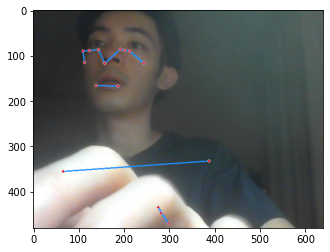

In [57]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## 3. Extract Keypoint Values
- Extracting the landmark values from the results
- Flatten them to 1D array to feed into LSTM
- If landmark not captured, fill with array of 0s

In [62]:
# Show the pose landmarks that was captured
results.pose_landmarks

landmark {
  x: 0.24774070084095
  y: 0.2455667108297348
  z: -1.1843081712722778
  visibility: 0.9691494703292847
}
landmark {
  x: 0.3009430170059204
  y: 0.1811092346906662
  z: -1.1041088104248047
  visibility: 0.9626727104187012
}
landmark {
  x: 0.31714388728141785
  y: 0.18394657969474792
  z: -1.104417324066162
  visibility: 0.9649668335914612
}
landmark {
  x: 0.33355623483657837
  y: 0.18778085708618164
  z: -1.1042152643203735
  visibility: 0.9674609899520874
}
landmark {
  x: 0.2258281707763672
  y: 0.182098388671875
  z: -1.078637719154358
  visibility: 0.9590281248092651
}
landmark {
  x: 0.19400504231452942
  y: 0.18549874424934387
  z: -1.0781339406967163
  visibility: 0.9561684727668762
}
landmark {
  x: 0.17342180013656616
  y: 0.18909096717834473
  z: -1.0786815881729126
  visibility: 0.9541824460029602
}
landmark {
  x: 0.38271626830101013
  y: 0.2434673309326172
  z: -0.7004262208938599
  visibility: 0.9761441349983215
}
landmark {
  x: 0.17809848487377167
  y: 0.2

In [63]:
# Testing, getting all the landmarks from pose
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [64]:
pose

[array([ 0.2477407 ,  0.24556671, -1.18430817,  0.96914947]),
 array([ 0.30094302,  0.18110923, -1.10410881,  0.96267271]),
 array([ 0.31714389,  0.18394658, -1.10441732,  0.96496683]),
 array([ 0.33355623,  0.18778086, -1.10421526,  0.96746099]),
 array([ 0.22582817,  0.18209839, -1.07863772,  0.95902812]),
 array([ 0.19400504,  0.18549874, -1.07813394,  0.95616847]),
 array([ 0.1734218 ,  0.18909097, -1.07868159,  0.95418245]),
 array([ 0.38271627,  0.24346733, -0.70042622,  0.97614413]),
 array([ 0.17809848,  0.24002576, -0.47694501,  0.96286672]),
 array([ 0.29271281,  0.34985438, -1.02616465,  0.97346753]),
 array([ 0.21733384,  0.34614143, -0.98999894,  0.97275573]),
 array([ 0.60757077,  0.69273847, -0.53544396,  0.98272866]),
 array([ 0.10398885,  0.73998189, -0.18307564,  0.94391936]),
 array([ 0.68997228,  1.2104224 , -1.17794979,  0.7719931 ]),
 array([-0.0171174 ,  1.22978103, -0.6983099 ,  0.16256404]),
 array([ 0.5279969 ,  1.00736487, -1.81329119,  0.8318876 ]),
 array([

In [25]:
# in list comprehension form
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
# face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [21]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [22]:
# Assign output numpy array to variable
result_test = extract_keypoints(results)

In [23]:
# Print numpy variable
result_test

array([ 0.28550807,  0.31009305, -1.60173321, ...,  0.        ,
        0.        ,  0.        ])

In [24]:
# Save numpy array as a file
np.save('0', result_test)

In [25]:
# Load the numpy file
# np.load('0.npy')

## 4. Setup Folders for Collection

In [32]:
actions = np.array(['hire', 'me', 'please', 'Google'])

In [10]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('hire_me_please_google') 

# Actions that we try to detect
actions = np.array(['hire', 'me', 'please', 'Google'])

# Thirty videos worth of data
no_sequences = 15

# Videos are going to be 30 frames in length
sequence_length = 30

In [11]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## 5. Collect Keypoint Values for Training and Testing

In [9]:
# Test camera position
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [12]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions (hello, thanks, ily)
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length, each frame, 30 frames of keypoints for each video
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [8]:
cap.release()
cv2.destroyAllWindows()

## 6. Preprocess Data and Create Labels and Features

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_map = {label:num for num, label in enumerate(actions)}

In [15]:
label_map

{'hire': 0, 'me': 1, 'please': 2, 'Google': 3}

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
# (videos, frames, keypoints)
np.array(sequences).shape

(60, 30, 258)

In [18]:
# (videos * labels)
np.array(labels).shape

(60,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(60, 30, 258)

In [21]:
# one hot encode y variables
y = to_categorical(labels).astype(int)

In [28]:
# Skip train test split
X_train = X
y_train = y

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [29]:
y_test.shape

NameError: name 'y_test' is not defined

## 7. Build and Train LSTM Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [23]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [34]:
model = Sequential()
# 3 LSTM layers
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [35]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [30]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.4095 - categorical_accuracy: 0.2812WARNING:tensorflow:From C:\Users\wushen\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2/2 [==============================] - 1s 533ms/step - loss: 1.4151 - categorical_accuracy: 0.2833
Epoch 2/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.3447 - categorical_accuracy: 0.5000
Epoch 3/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.2735 - categorical_accuracy: 0.3667
Epoch 4/1000
2/2 [==============================] - 0s 25ms/step - loss: 1.5418 - categorical_accuracy: 0.5833
Epoch 5/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.7333 - categorical_accuracy: 0.2500
Epoch 6/1000
2/2 [==============================] - 0s 29ms/step - lo

2/2 [==============================] - 0s 32ms/step - loss: 1.0886 - categorical_accuracy: 0.4833
Epoch 140/1000
2/2 [==============================] - 0s 50ms/step - loss: 1.0829 - categorical_accuracy: 0.5000
Epoch 141/1000
2/2 [==============================] - 0s 43ms/step - loss: 1.0790 - categorical_accuracy: 0.5000
Epoch 142/1000
2/2 [==============================] - 0s 32ms/step - loss: 1.0694 - categorical_accuracy: 0.4833
Epoch 143/1000
2/2 [==============================] - 0s 35ms/step - loss: 1.0532 - categorical_accuracy: 0.4833
Epoch 144/1000
2/2 [==============================] - ETA: 0s - loss: 1.0332 - categorical_accuracy: 0.50 - 0s 45ms/step - loss: 1.0332 - categorical_accuracy: 0.5000
Epoch 145/1000
2/2 [==============================] - 0s 43ms/step - loss: 1.0158 - categorical_accuracy: 0.5000
Epoch 146/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.9936 - categorical_accuracy: 0.5833
Epoch 147/1000
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 49ms/step - loss: 1.3578 - categorical_accuracy: 0.2833
Epoch 283/1000
2/2 [==============================] - 0s 50ms/step - loss: 1.3576 - categorical_accuracy: 0.2667
Epoch 284/1000
2/2 [==============================] - 0s 48ms/step - loss: 1.3571 - categorical_accuracy: 0.2667
Epoch 285/1000
2/2 [==============================] - 0s 50ms/step - loss: 1.3568 - categorical_accuracy: 0.2833
Epoch 286/1000
2/2 [==============================] - 0s 51ms/step - loss: 1.3563 - categorical_accuracy: 0.3000
Epoch 287/1000
2/2 [==============================] - 0s 50ms/step - loss: 1.3559 - categorical_accuracy: 0.3667
Epoch 288/1000
2/2 [==============================] - 0s 47ms/step - loss: 1.3554 - categorical_accuracy: 0.4333
Epoch 289/1000
2/2 [==============================] - 0s 51ms/step - loss: 1.3549 - categorical_accuracy: 0.4833
Epoch 290/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.3543 - categorical_accuracy: 0.466

KeyboardInterrupt: 

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            82688     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 237,284
Trainable params: 237,284
Non-trainable params: 0
__________________________________________________

## 8. Make Predictions

In [35]:
res = model.predict(X_test)

In [39]:
actions[np.argmax(res[1])]

'thanks'

In [40]:
actions[np.argmax(y_test[1])]

'thanks'

## 9. Save Weights

In [32]:
model.save('action_hireme.h5')

In [29]:
del model

In [11]:
# Original model: hello, thanks
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# model.load_weights('action_v1.h5')

In [36]:
model.load_weights('action_hireme.h5')

## 10. Evaluation using Confusion Matrix and Accuracy

In [33]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [34]:
yhat = model.predict(X_test)

NameError: name 'X_test' is not defined

In [44]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [45]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]]], dtype=int64)

In [46]:
accuracy_score(ytrue, yhat)

1.0

## 11. Test in Real Time

In [33]:
# from scipy import stats

In [126]:
# To do visualization of word probabilityies
colors = [(245,117,16), (117,245,16), (16,117,245), (100,255,125)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [127]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

IndexError: index 2 is out of bounds for axis 0 with size 2

<Figure size 1296x1296 with 0 Axes>

In [129]:
# 1. New detection variables
sequence = []        #collect the 30 frames to generate a prediction
sentence = []        #concat history of detections
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]   
        
#         once sequence has 30 frames
        if len(sequence) == 30: 
            # model expects (1, 30, 258), current sequence (30, 258)
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:    #append only if next action is different
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:          #just grab the last 5 values when sentence has more than 5 words
                sentence = sentence[-5:]

#             # Viz probabilities
#             image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [130]:
cap.release()
cv2.destroyAllWindows()

In [16]:
np.expand_dims(sequence, axis=0).shape

(1, 30, 258)

# Debugging

Using the original action.h5, trained on hello and thanks
- debug output issue
- the face points are also included

In [13]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [14]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(60,20,220), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(0,255,30), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [15]:
# Check camera set up
cap = cv2.VideoCapture(0)
# Set mediapipe model: instantiate the model to fit into detection function
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read frame from webcam, return value, frame: image from webcam
        ret, frame = cap.read()

        # Feed webcam image to mediapipe to Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [21]:
actions = np.array(['hello', 'thanks'])

In [22]:
# Original model: hello, thanks
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.load_weights('action_v1.h5')